#### **Connect to the database where the .csv data file has been imported as a table**

In [1]:
import sqlite3
from sqlite3 import Error


def connection(db_file):
    """ create a database connection to the SQLite database specified
    by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

conn = connection('../data/input/chinook.db')

**A new table is created with the clean records**

In [2]:
def create_clean_sample(conn):
    """
    Creates table with clean records from the sample dataset
    :param conn: connection object
    :return:None
    """
    cur = conn.cursor()
    cur.execute(
        f"""Create TABLE IF NOT EXISTS cleaned_sample AS
            SELECT
            user_id,
            datetime(substr(registration_date , 7, 4) || '-' || substr(registration_date , 4, 2) || '-' || substr(registration_date , 1, 2) || ' ' || substr(registration_date, 12, 2) || ':' || substr(registration_date, 15, 2) || ':' || substr(registration_date, 18, 2)) as registration_date,
            REPLACE(REPLACE(app_version, 'unknown', 'unknown_version'), '#N/A', 'unknown_version') as app_version,
            REPLACE(REPLACE(REPLACE(user_channel, 'unknown', 'unknown_channel'), 'n/a', 'unknown_channel'), '#N/A', 'unknown_channel') as user_channel,
            datetime(substr(submission_date, 7, 4) || '-' || substr(submission_date, 4, 2) || '-' || substr(submission_date, 1, 2) || ' ' || substr(submission_date, 12, 2) || ':' || substr(submission_date, 15, 2) || ':' || substr(submission_date, 18, 2)) as submission_date,
            REPLACE(REPLACE(user_platform, '#N/A', 'unknown_platform'), 'n/a', 'unknown_platform') as user_platform,
            LOWER(REPLACE(REPLACE(City, '#N/A', 'unknown_city'), 'n/a', 'unknown_city')) as city,
            LOWER(Country) as country
            FROM taxfix"""
    )

    return None

create_clean_sample(conn)

#### **What is the most common channel for acquiring users? What is the second most common channel for acquiring users?**

In [3]:
def get_top_n_acquirers(conn, n):
    """
    Selects most successful acquirer channels
    :param conn: connection object
    :param n: number of elements in ranking, descending
    :return:
    """
    cur = conn.cursor()
    cur.execute(
        f"""SELECT user_channel AS channel,
        count(user_id) AS number_users
        FROM cleaned_sample
        GROUP BY user_channel
        ORDER BY number_users DESC 
        LIMIT {n}"""
    )

    rows = cur.fetchall()

    for i, j in enumerate(rows):
        print(f"'{j[0]}' is the {i+1} channel with {j[1]} users acquired")

    return None


#Execute the previously defined function
get_top_n_acquirers(conn, 2)

'organic' is the 1 channel with 9303 users acquired
'uac' is the 2 channel with 5587 users acquired


#### **How much time does it usually take for a user from their registration to submit their tax declaration?**

In [4]:
def get_avg_submission_time(conn):
    """
    Selects and prints the average time a user takes to submit their tax
    declaration since they registered
    :param conn: connection object
    :return: integer of number of average days
    """
    cur = conn.cursor()
    cur.execute(
        f"""
        select 
        round(avg(STRFTIME('%s' ,submission_date) - STRFTIME('%s' ,registration_date)) * 1.0 / 60 / 60) as avg_time
        from cleaned_sample
        where submission_date is not null
        """
    )

    row = cur.fetchall()
    hours = row[0][0]

    print(
        f"Average time a user took to complete their tax submission "
        f"since they've registered was {hours} hours"
    )
    
    return hours


#Execute the previously defined function and assign the value to variable for later user in visualization.
avg_time = get_avg_submission_time(conn)

Average time a user took to complete their tax submission since they've registered was 12.0 hours


In [5]:
avg_time

12.0

#### **Include a data visualization**

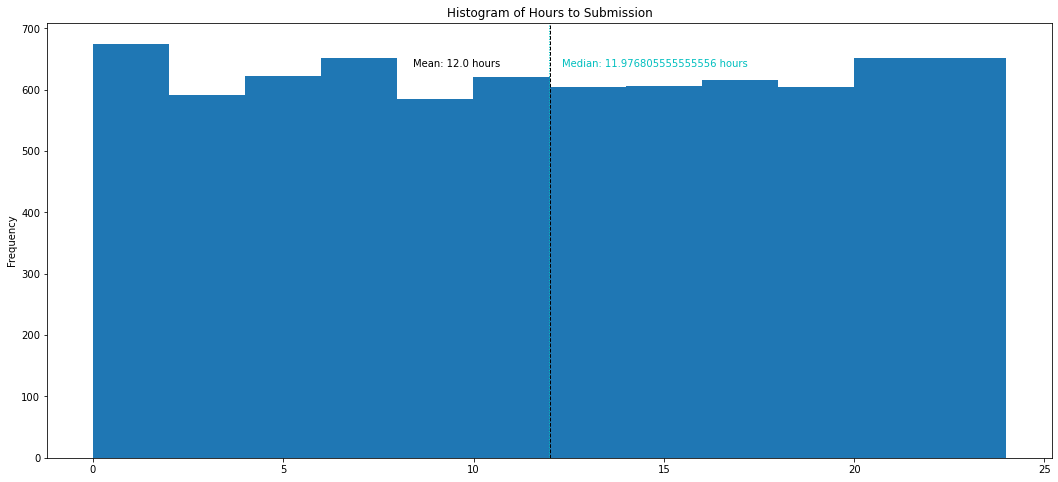

In [6]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt


def get_submission_time_user(conn):
    """
    Provides list user, submission and registration dates, and difference
    :param conn: connection object
    :return:list
    """

    cur = conn.cursor()
    cur.execute(
        f"""
        select 
        user_id,
        submission_date,
        registration_date,
        (STRFTIME('%s' ,submission_date) - STRFTIME('%s' ,registration_date)) *1.0 / 60 / 60 as difference
        from cleaned_sample
        order by difference DESC"""
    )

    rows = cur.fetchall()

    return rows


def create_df(timings_list):

    data = timings_list
    cols = ['user', 'submission_time', 'registration_time', 'hours_difference']
    df_user_timings = pd.DataFrame(data, columns=cols)
    df_user_timings['user'] = df_user_timings['user'].astype('category')

    return df_user_timings


def create_viz(df, constant):
    mean_hours = constant
    median_hours = df['hours_difference'].median()

    series_user_timing = df['hours_difference']
    data_viz = series_user_timing.plot.hist(
        bins=12, figsize=(18, 8), xlabel='days', title='Histogram of Hours to Submission'
    )
    # Plot mean and median
    data_viz.axvline(mean_hours, color='k', linestyle='dashed', linewidth=1)
    data_viz.axvline(median_hours, color='c', linestyle='dotted', linewidth=1)

    # Add text to lines
    min_ylim, max_ylim = plt.ylim()
    data_viz.text(mean_hours * 0.7, max_ylim * 0.9, f'Mean: {mean_hours} hours')
    data_viz.text(median_hours * 1.03, max_ylim * 0.9, f'Median: {median_hours} hours', color='c')

    # Export viz to .png file
    data_viz.figure.savefig("../data/output/avg_sub_time_user.png", facecolor='w')

    return None


#Execute previously defined function
user_timings = get_submission_time_user(conn)
df_user_timings = create_df(user_timings)
create_viz(df_user_timings, avg_time)

Having a look to the histogram the uniformity of the distribution can be appreciated. The submission time ranges from barely seconds up to almost a whole day, since a user is registered. Thus, based on the sample datase **it could be infered that once the user has registered, they have up to 24 hours to submit their tax declaration**.

#### **Create an alert via SQL. This will alert every time a user submits before registering himself, which would indicate that there is an issue in the data processing pipeline**

In [7]:
def create_trigger(conn):
    """
    """

    cur = conn.cursor()
    cur.execute(
        f"""CREATE TRIGGER IF NOT EXISTS sub_time_check
            AFTER INSERT ON taxfix
            FOR EACH ROW
            WHEN 
                submission_date IS NOT NULL 
                AND registration_date IS NULL
            BEGIN 
                INSERT INTO failed_records (
                    user_id,
                    registration_date,
                    app_version,
                    user_channel,
                    submission_date,
                    user_platform,
                    city,
                    country
                )
                VALUES (
                    taxfix.user_id,
                    taxfix.registration_date,
                    taxfix.app_version,
                    taxfix.user_channel,
                    taxfix.submission_date,
                    taxfix.user_platform,
                    taxfix.city,
                    taxfix.country
                );
            END;"""
    )

    return None

create_trigger(conn)

#### **The conversion rate is defined as “users that submit tax declarations” / “users that register”. Try to forecast the future daily values of the conversion rate. How would you take into consideration the seasonality effect?**

Dataset's overall conversion rate is 0.3


INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-10-31 00:00:00 and 2020-11-06 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


4.59

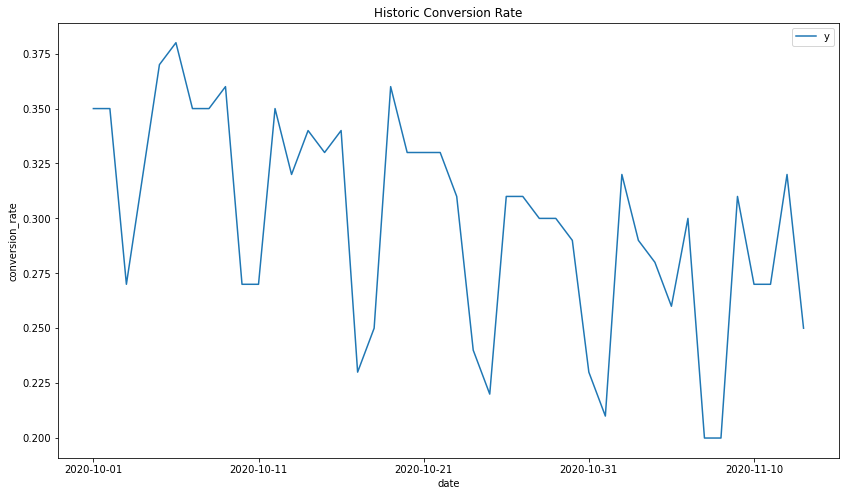

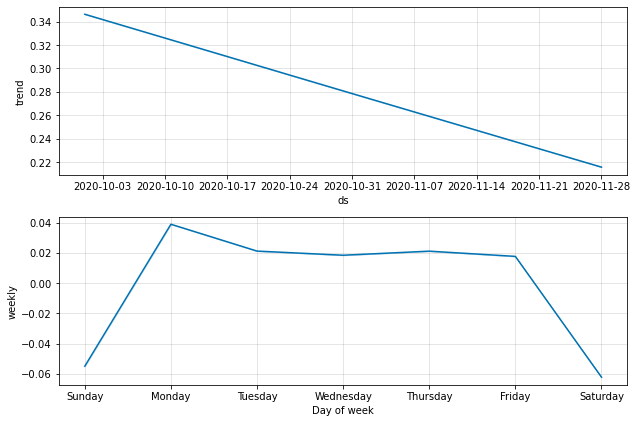

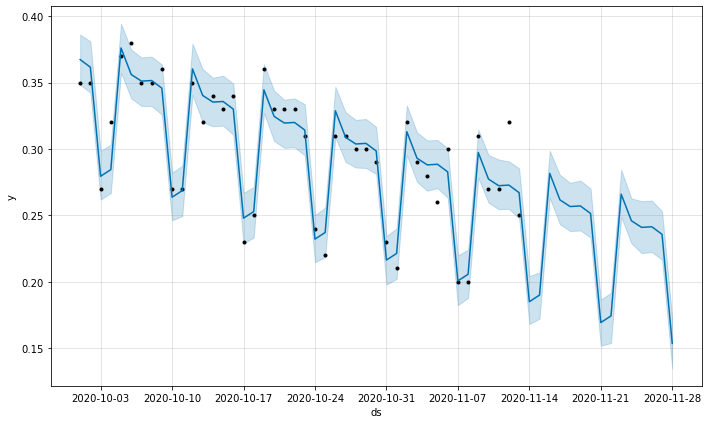

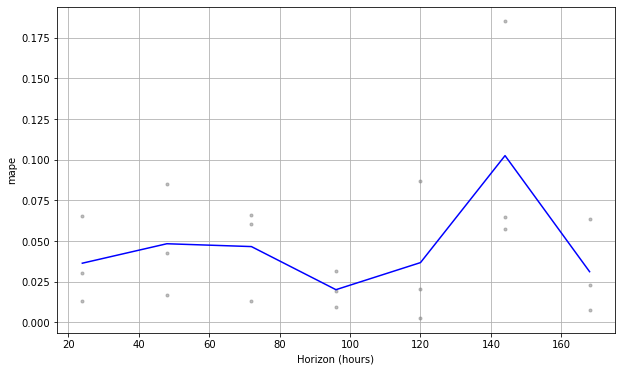

In [26]:
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

def get_raw_table(conn):
    """
    Selects number of registered users, submissions and their relation
    by registration date
    :param conn:connection object
    :return: list of tuples
    """
    cur = conn.cursor()
    cur.execute(
        f"""SELECT * FROM cleaned_sample"""
    )

    rows = cur.fetchall()

    return rows


def get_raw_df(rows):
    
    data = rows
    cols = [
        'user_id', 'registration_date', 'app_version', 'user_channel', 
        'submission_date', 'user_platform', 'city', 'country'
    ]
    raw_df = pd.DataFrame(data, columns=cols)
    
    return raw_df


def wrangle_df(df):
    
    
    #Obtain overall conversion rate of the data set
    conversion_rate = (
         round(1 - df['submission_date'].isna().sum() / len(df), 2)
    )
    print(f"Dataset's overall conversion rate is {conversion_rate}")
    
    #Create column to show which users ended-up converting
    df['converted'] = np.where(df['submission_date'].isna(), 0, 1)
    
    
    # Leave the date only
    df[['registration_date', 'submission_date']] = (
        df[['registration_date', 'submission_date']]
        .apply(lambda x: x.str[:10], axis=1)
    )
    
    return df


def get_prophet_df(df):
    
    #Group the df and calculate the conversion rate per day
    df = (
        df[['registration_date', 'converted', 'user_id']]
        .groupby(['registration_date'])
        .agg({'converted': 'sum', 'user_id': 'count'})
        .reset_index()
    )
    df['conversion_rate'] = round(df['converted'] / df['user_id'], 2)
    
    #Rename features for prophet to use the df
    new_names = {'registration_date': 'ds', 'conversion_rate': 'y'}
    df = df[['registration_date', 'conversion_rate']].rename(columns=new_names)
    
    return df


def create_viz_conversion_rate(df):
    
    data_viz = df[:-1].plot(x='ds',
    figsize=(14, 8), xlabel='date', ylabel='conversion_rate',
    title='Historic Conversion Rate')
    
    # Export viz to .png file
    data_viz.figure.savefig("../data/output/hist_conversion_rate.png", facecolor='w')
    
    return None


def forecast_with_prophet(df):
    
    m = Prophet(daily_seasonality=False, yearly_seasonality=False)
    train = df[df['ds'] < '2020-11-14']
    #train = df[df['ds'] < '2020-11-01']
    
    m.fit(train)
    future = m.make_future_dataframe(periods=15)
    forecast = m.predict(future)
    

    fig = m.plot_components(forecast)
    fig.savefig("../data/output/components.png", facecolor='w')
    
    fig = m.plot(forecast)
    fig.savefig("../data/output/forecast.png", facecolor='w')
    
    return m


def obatin_mape(model, train_days, horizon_days, period_days):
    
    cv_results = (
        cross_validation(
            model=model, initial=train_days, horizon=horizon_days, period=period_days
        )
    )
    
    #print(cv_results)
    cv_performance = performance_metrics(cv_results)
    #print(cv_performance)
    
    y_actual, y_pred = np.array(cv_results['y']), np.array(cv_results['yhat'])
    overall_mape =  round(
        np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100, 2
    )
    
    fig = plot_cross_validation_metric(cv_results, metric='mape')
    
    return overall_mape
    

    
rows = get_raw_table(conn)
raw = get_raw_df(rows)
cleaned_df = wrangle_df(raw)
prophet_df = get_prophet_df(cleaned_df)
create_viz_conversion_rate(prophet_df)
model = forecast_with_prophet(prophet_df)
obatin_mape(model, '30 days', '7 days', '3 days')

The small sample dataset shows a **downward linear trend** and a **stable weekly seasonality** through most weekdays, apart from Monday's submission upticks and weekends poorer conversions. The last day of the time series (**2020-11-14**) has been left out from the train dataset because the actual conversion rate of a given day can only be known at the end of the next day, when the theoretical 24 hour time for registered users to submit their tax declaration is up. Intraday and yearly seasonalities have been disabled as the time series comprises 45 days only. Having a complete year of records probably would present us with a year seasonality where conversion rates are better the closer deadlines are due, although it is just a guess.

In order to improve the forecast, additional regressors such as the the app_version, user_channel and user_platform would be worthy features to add on to the model, as they likely would affect the probability of a user to submit their tax declaration. The city might not be a relevant feature to consider, unless there is certain localized marketing campaing or similar action active during the series.
Model parameters such as changepoint_range, changepoint_prior_scale, holidays or holidays_prior_scale haven't been tweaked. These additions and others, suchs as obtaining the model MAPE (Mean Average Percentage Error), would make more sense to implement if the dataset comprised at least a year of records, given that the resulting trained model may overfit the train set.

Nevertheless, for the sake of this assignment, the MAPE has been calculated by testing the model 3 times for an horizon of 7, obtaining a ~4%. This is quite decent given the short time series. In the last plot above one can see the MAPE represented per hours. The forecast for Thursdays seems to be the most accurate, whereas Saturdays MAPE more than doubles the average for the whole week.

#### **In this period of time, we have noticed that the conversion rate for people that register in our application is dropping.This might indicate problems in our product and our business model:**

#### **What insights have you discovered in the provided dataset? Which factors affect the situation?**

These are the percentages of missing records per for columns with at least one value missing
app_version      0.273188
user_channel     0.066143
user_platform    0.035345
city             0.533849
dtype: float64
Max positive correlated category with conversion is channel_uac: 0.0650075398284489
Max negative correlated category with conversion is channel_organic: -0.13739984886074455


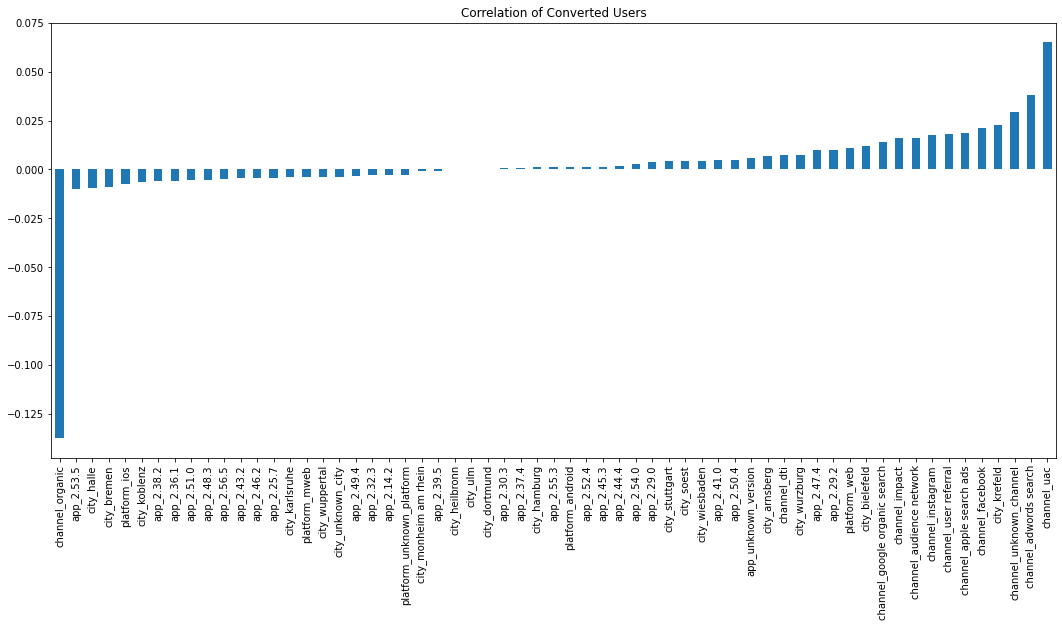

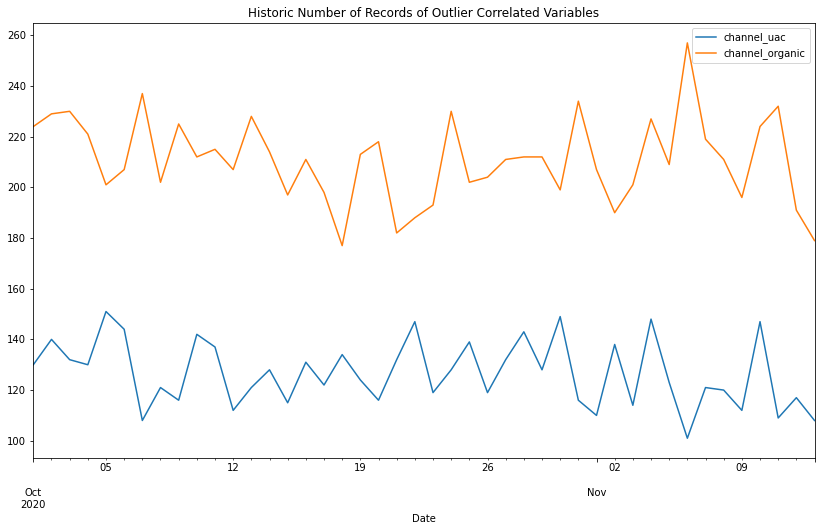

In [42]:
%matplotlib inline


def analysis(df):
    
    #Null analysis
    percent_missing = (
        df[['app_version', 'user_channel', 'user_platform', 'city']]
        .replace('unknown', np.nan, regex=True)
        .isnull()
        .sum() 
        / len(df)
    )
    print('These are the percentages of missing records per for columns with at least one value missing')
    print(percent_missing)
    
    #One-Hot encoding applied to features with missing values
    one_hot_cols = ['app_version', 'user_channel', 'user_platform', 'city']
    prefixes_cols = ['app', 'channel', 'platform', 'city']
    df_one_hot = (
        pd.get_dummies(df, columns=one_hot_cols, prefix=prefixes_cols)
    )
    #print(df_one_hot.describe())
    
    #Obtain correlation series for 'converted' column and values
    
    matrix = df_one_hot.iloc[:, 4:] #From 'converted' feature until last one-hot encoded
    corr_matrix = matrix.corr()['converted'].sort_values()[:-1] #Drop Converted from corr matrix
    #print(corr_matrix)
    id_max = corr_matrix.idxmax()
    max_value = corr_matrix.max()
    id_min = corr_matrix.idxmin()
    min_value = corr_matrix.min()
    
    print(f"Max positive correlated category with conversion is {id_max}: {max_value}")
    print(f"Max negative correlated category with conversion is {id_min}: {min_value}")
    
    corr_matrix.plot.bar(figsize=(18, 8), title='Correlation of Converted Users')
    
    #Closer look to correlation outliers
    grouped_outliers = (
        matrix[['converted', id_max, id_min]].groupby(['converted']).sum()
    )
    
    #Past number of registered users per maximum and minimum category
    time_line_outliers = (
        df_one_hot[['registration_date', id_max, id_min]]
        .groupby(['registration_date'])
        .sum().reset_index()
    )
    
    return time_line_outliers


def create_timeline_corr_variables(df):

    df['registration_date'] = pd.to_datetime(df['registration_date'], format='%Y-%m-%d')
    corr_time_series = df[:-1]
    data_viz = corr_time_series.plot(x='registration_date',
        figsize=(14, 8), xlabel='Date', 
        title='Historic Number of Records of Outlier Correlated Variables'
    )
    
    # Export viz to .png file
    data_viz.figure.savefig("../data/output/correlated_values.png", facecolor='w')
    

analysed_df = analysis(cleaned_df)
create_timeline_corr_variables(analysed_df)

**App_version and city** are features whose values are often missing in **27%** and **53%** of records, repectively. One could thought that was the reason behind the drop in conversion rates lately, but it is hardly possible, as **these features seem to be quite uncorrelated with the conversion rates** (corr ~ 0). Overall **there is are no strong correlations** between converted users and the features, being the **outliers two acquiring channel, 'uac' and 'organic'**. 'uac' has the **maximum positive correlation** among the others with **6%**, whereas 'organic' is located at the other side of the range holding a **maximum negative correlation of 13%**. Thus, the more organic users are acquired, the lesser users are converted, and the contrary in the case of 'uac', although to a lesser effect.

#### **What additional details would help you gain a clearer understanding of the data? How would you look deeper into the data?**

Since the product is not available in Spain, I can't go through the complete tax submission process to better analyse what other data points would be worth having available in the dataset. Nevertheless, I downloaded the app, registered and reached until the submission of the employer payment slip in the tax declaration process.
In order to gain a clearer understanding of the data that I'm presented with, I think it would be valuable to have the records of a whole year, as well as a series of events that have taken place during the year (deadlines, special offers, localized campaigns, etc.), and more datapoints suchs as whether a user submitted their payment slip, the number of attempts it took them to verify their identity or the estimated adquisition cost of a registered users.

These additions would allow me to detect other seasonalities in the conversion rates (quaterly, bi-annual o annual), add chainpoints to the forecast model and improve it, or infer which acquisition channels work fine with respect to the registered user cost.

#### **What are your suggestions based on the insights? Which strategic and tactical next steps do you recommend?**

The largest acquisition channel is 'organic' but is negatively correlated to user conversion, meaning, a high proportion of organic acquired users tend not to complete their submission process. It is key to attract the right users and have them complete the submission. Thus a depper study of the 'buying persona' would help understanding their pain points during the submission process. Assuming that SEO is part of this channel, I would invest more on it, although it's a long-run strategy.

In addition, 'uac' acquired users are perfoming in coversion rates relatively better than the rest, although not outstanding. I would reconsider the cost of this strategy based on the mild correlation with conversion rates, assuming that 'uac' comprises PPC campaigns (pay-per-click).